# Choroid Plexus and Thalamic Nuclei

## Setup

Formatting

<style>
body, .jp-Notebook {
    font-family: 'Source Sans 3', serif !important;
}


table {
    font-family: 'Source Sans 3', sans-serif;
}

table td, table th {
    text-align: center !important;
}

/* Optional: keep first column left-aligned if it contains labels */
table td:first-child, table th:first-child {
    text-align: left !important;
}
</style>

### Imports

In [48]:
from warnings import simplefilter

import pandas as pd

simplefilter(action="ignore", category=pd.errors.PerformanceWarning)
simplefilter(action="ignore", category=DeprecationWarning)
simplefilter(action="ignore", category=FutureWarning)

import re
import textwrap
from pathlib import Path
from pyprocessmacro import Process
import statsmodels
from statsmodels.stats.multitest import multipletests
from IPython.display import clear_output

import os
import numpy as np
import pyperclip
import statsmodels.api as sm
import statsmodels.formula.api as smf
from matplotlib import colormaps
from scipy import stats
from IPython.display import Markdown, display
from io import StringIO
import matplotlib.pyplot as plt
from collections import defaultdict
import subprocess

import sys

simplefilter(
    action="ignore", category=statsmodels.tools.sm_exceptions.InvalidTestWarning
)

sys.path.insert(0, "/home/srs-9/Projects/ms_mri/analysis/thalamus/helpers")

import helpers
import utils
import regression_utils as regutils
import my_namespace
from my_python_utils import smart_title, reload_recursive

#### Reload Modules

In [49]:
reload_recursive(regutils)
reload_recursive(helpers)
reload_recursive(utils)
reload_recursive(my_namespace)

import utils
from utils import zscore
from my_namespace import presentation_cols, presentation_cols_both_ps, colors

### Load Data

#### Clinical and Volumes

In [50]:
fig_path = Path(
    "/home/srs-9/Projects/ms_mri/analysis/thalamus/results/figures_tables/6-Thalamic_nuclei_and_disability"
)
if not os.path.exists(fig_path):
    os.makedirs(fig_path)

data = utils.load_data("/home/srs-9/Projects/ms_mri/analysis/thalamus/results/data.csv")

MS_patients = data["dz_type2"] == "MS"
NONMS_patients = data["dz_type2"] == "!MS"
NIND_patients = data["dz_type5"] == "NIND"
OIND_patients = data["dz_type5"] == "OIND"
RMS_patients = data["dz_type5"] == "RMS"
PMS_patients = data["dz_type5"] == "PMS"

thalamic_nuclei = [2, 4, 5, 6, 7, 8, 9, 10, 11, 12]
deep_grey = [13, 14, 26, 27, 28, 29, 30, 31, 32]
thalamic_nuclei_str = [str(i) for i in thalamic_nuclei]

hips_thomas_ref = pd.read_csv(
    "/home/srs-9/Projects/ms_mri/data/hipsthomas_struct_index.csv", index_col="index"
)["struct"]
hips_thomas_invref = pd.read_csv(
    "/home/srs-9/Projects/ms_mri/data/hipsthomas_struct_index.csv", index_col="struct"
)["index"]

data_ms = data[MS_patients]
data_ms_z = zscore(data_ms)

grouped_nuclei = ["medial", "posterior", "ventral", "anterior"]

nuclei_rename_index = {k: f"**{k}**" for k in grouped_nuclei}

### Functions

In [51]:
def run_R_script(p1, p2, p12, nobs):
    """
    Call R script to run Williams-Hotelling test and return p-value.

    Parameters:
    -----------
    p1 : float
        First correlation coefficient
    p2 : float
        Second correlation coefficient
    p12 : float
        Correlation between the two variables
    nobs : int
        Number of observations

    Returns:
    --------
    float
        The p-value from the Williams-Hotelling test
    """
    # Path to the R script (adjust this to where your R script is located)
    r_script_path = (
        "/home/srs-9/Projects/ms_mri/analysis/thalamus/run_williams_hotelling.R"
    )

    # Convert arguments to strings
    args = [str(p1), str(p2), str(p12), str(nobs)]

    # Call R script
    try:
        result = subprocess.run(
            ["Rscript", r_script_path] + args,
            capture_output=True,
            text=True,
            check=True,
        )

        # Parse the output (p-value)
        p_value = float(result.stdout.strip())
        return p_value

    except subprocess.CalledProcessError as e:
        print(f"Error running R script: {e}")
        print(f"stdout: {e.stdout}")
        print(f"stderr: {e.stderr}")
        raise
    except ValueError as e:
        print(f"Error parsing R output: {e}")
        print(f"R output was: {result.stdout}")
        raise


def thalamus_influence_analysis(model_data, influenced_var, covariates):
    residualized_vars = {}
    for var in ["medial", "posterior", "anterior", "ventral", "THALAMUS_1"] + [
        influenced_var
    ]:
        residualized_vars[var] = regutils.residualize_vars(
            model_data,
            dependent_var=var,
            independent_vars=covariates,
        )

    residualized_vars = pd.DataFrame(residualized_vars).dropna()

    nobs = residualized_vars[influenced_var].shape[0]

    structs = ["medial", "posterior", "anterior", "ventral"]
    working_structs = structs.copy()

    nuclei_comps = {}
    thalamus_comps = {}
    pearson_results = {}
    pearson_results["THALAMUS_1"] = stats.pearsonr(
        residualized_vars["THALAMUS_1"], residualized_vars[influenced_var]
    )
    for i, struct in enumerate(structs):
        pearson_results[struct] = stats.pearsonr(
            residualized_vars[struct], residualized_vars[influenced_var]
        )

        thalamus_comps[f"{struct} vs THALAMUS_1"] = run_R_script(
            pearson_results["THALAMUS_1"][0],
            pearson_results[struct][0],
            stats.pearsonr(residualized_vars["THALAMUS_1"], residualized_vars[struct])[
                0
            ],
            nobs,
        )
        if thalamus_comps[f"{struct} vs THALAMUS_1"] >= 0.05:
            sign = "="
        elif abs(pearson_results[struct][0]) > abs(pearson_results["THALAMUS_1"][0]):
            sign = ">"
        else:
            sign = "<"
        thalamus_comps = {re.sub(r"vs", sign, k): v for k, v in thalamus_comps.items()}

    for i, struct1 in enumerate(structs):
        working_structs = working_structs[1:]
        for struct2 in working_structs:
            nuclei_comps[f"{struct1} vs {struct2}"] = run_R_script(
                pearson_results[struct1][0],
                pearson_results[struct2][0],
                stats.pearsonr(residualized_vars[struct1], residualized_vars[struct2])[
                    0
                ],
                nobs,
            )
            if nuclei_comps[f"{struct1} vs {struct2}"] >= 0.05:
                sign = "="
            elif abs(pearson_results[struct1][0]) > abs(pearson_results[struct2][0]):
                sign = ">"
            else:
                sign = "<"
            nuclei_comps = {re.sub(r"vs", sign, k): v for k, v in nuclei_comps.items()}

    return pearson_results, thalamus_comps, nuclei_comps


def plot_moderated_mediation(
    model,
    moderator,
    xlabel=None,
    ylabel=None,
    title=None,
    plot_colors=None,
    jitter_percent=None,
):
    if xlabel is None:
        xlabel = moderator
    if ylabel is None:
        ylabel = "Standardized Indirect Effect"
    if title is None:
        title = "Conditional Indirect Effect of X on Disability Through Mediator"
    if plot_colors is None:
        plot_colors = [colors["dark blue1"], colors["dark red2"], colors["dark green1"]]
    if jitter_percent is None:
        jitter_percent = [0, 0.02, 0.04]

    # Create the plot
    fig, ax = plt.subplots(figsize=(8, 6))

    # Data
    indirect_model = model.indirect_model.coeff_summary()
    indirect_model.set_index("Mediator", inplace=True)

    for i, mediator in enumerate(model.mediators):
        t2lv_values = indirect_model.loc[mediator, moderator]
        jitter = (t2lv_values[1] - t2lv_values[0]) * jitter_percent[i]
        indirect_effects = indirect_model.loc[mediator, "Effect"]
        ci_lower = indirect_model.loc[mediator, "BootLLCI"]
        ci_upper = indirect_model.loc[mediator, "BootULCI"]

        # Calculate errors
        errors_lower = indirect_effects - ci_lower
        errors_upper = ci_upper - indirect_effects
        errors = np.array([errors_lower, errors_upper])

        # Plot line and points
        # old color: '#2E86AB'
        label = smart_title(re.sub(r"_", " ", mediator))
        ax.plot(
            t2lv_values + jitter,
            indirect_effects,
            "-o",
            color=plot_colors[i],
            linewidth=2,
            markersize=8,
            alpha=0.8,
            label=label,
        )

        # Add error bars
        ax.errorbar(
            t2lv_values + jitter,
            indirect_effects,
            yerr=errors,
            fmt="o",
            markersize=10,
            color=plot_colors[i],
            ecolor=plot_colors[i],
            capsize=6,
            capthick=2.5,
            linewidth=2.5,
            markeredgewidth=2,
            markeredgecolor="white",
        )

    # Add horizontal line at zero
    ax.axhline(y=0, color="gray", linestyle="--", linewidth=1, alpha=0.7)

    # Customize plot
    ax.set_xticks([-1, 0, 1])
    ax.set_xticklabels(["Low\n(-1 SD)", "Mean\n(0 SD)", "High\n(+1 SD)"])
    ax.set_xlabel(xlabel, fontsize=12, fontweight="bold")
    ax.set_ylabel(ylabel, fontsize=12, fontweight="bold")
    ax.set_title(title, fontsize=13, fontweight="bold", pad=20)
    # ax.set_ylim(0, 0.25)
    # ax.grid(True, alpha=0.3, linestyle='-', linewidth=0.5)
    ax.set_axisbelow(True)

    ax.axhline(y=0, color="#666666", linestyle="--", linewidth=1.5, alpha=0.5)
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.grid(True, alpha=0.2, linestyle="-", linewidth=0.5, axis="y")
    ax.legend()

    plt.tight_layout()
    plt.show()

## Baseline Models of Disability

In [5]:
model_data = data_ms_z
save_path = fig_path / "edss_all_predictors.xlsx"
covariates = ["age", "Female", "tiv", "dzdur"]

outcomes = ["EDSS_sqrt", "SDMT"]

predictors = [
    "WBV",
    "GMV",
    "WMV",
    "WTV",
    "cortical_thickness",
    "CP",
    "T2LV_log1p",
    "PRL",
]

results, _, models = regutils.run_regressions(
    model_data,
    outcomes,
    predictors,
    covariates,
)


for outcome in outcomes:
    results_to_display = results[outcome]
    display_order = (
        results_to_display["coef"].apply(np.abs).sort_values(ascending=False).index
    )
    display(Markdown(f"`{outcome} ~ *predictor* + {' + '.join(covariates)}`"))
    display(
        Markdown(
            regutils.present_model(results_to_display, presentation_cols).to_markdown()
        )
    )

WBV, age, Female, tiv, dzdur, EDSS_sqrt
WBV, age, Female, tiv, dzdur, SDMT
WMV, age, Female, tiv, dzdur, SDMT


`EDSS_sqrt ~ *predictor* + age + Female + tiv + dzdur`

| predictor          |    coef |   p_fdr |     se | ci                |   R2 |
|:-------------------|--------:|--------:|-------:|:------------------|-----:|
| WBV                | -0.3837 | 0.00031 | 0.1013 | [-0.582, -0.185]  | 0.27 |
| GMV                | -0.2601 | 0.0026  | 0.0826 | [-0.422, -0.0982] | 0.26 |
| WMV                | -0.2526 | 0.0069  | 0.0903 | [-0.43, -0.0756]  | 0.26 |
| WTV                | -0.2553 | 7.9e-07 | 0.0479 | [-0.349, -0.161]  | 0.29 |
| cortical_thickness | -0.195  | 2.5e-05 | 0.0432 | [-0.28, -0.11]    | 0.27 |
| CP                 |  0.0535 | 0.22    | 0.0438 | [-0.0322, 0.139]  | 0.25 |
| T2LV_log1p         |  0.1762 | 5.5e-05 | 0.0414 | [0.095, 0.257]    | 0.27 |
| PRL                |  0.1024 | 0.015   | 0.0413 | [0.0216, 0.183]   | 0.25 |

`SDMT ~ *predictor* + age + Female + tiv + dzdur`

| predictor          |    coef |   p_fdr |     se | ci                |   R2 |
|:-------------------|--------:|--------:|-------:|:------------------|-----:|
| WBV                |  0.7144 | 3e-08   | 0.1262 | [0.467, 0.962]    | 0.24 |
| GMV                |  0.4034 | 0.0053  | 0.1426 | [0.124, 0.683]    | 0.2  |
| WMV                |  0.5467 | 7.6e-08 | 0.1001 | [0.35, 0.743]     | 0.22 |
| WTV                |  0.373  | 4.6e-10 | 0.0584 | [0.258, 0.487]    | 0.25 |
| cortical_thickness |  0.3614 | 1.5e-12 | 0.0491 | [0.265, 0.458]    | 0.25 |
| CP                 | -0.1556 | 0.0056  | 0.0562 | [-0.266, -0.0454] | 0.17 |
| T2LV_log1p         | -0.3245 | 4.6e-10 | 0.0506 | [-0.424, -0.225]  | 0.24 |
| PRL                | -0.1452 | 0.0053  | 0.0509 | [-0.245, -0.0454] | 0.17 |

### Effects of WTV and CT together

CT does not explain EDSS when WTV is included as a covariate. CT does a better job of expaining SDMT than WTV

In [ ]:
model_data = zscore(data[MS_patients])

exog_list = {
    "WBV": ["WBV"],
    "WTV": ["WTV"],
    "CT": ["CT"],
    "WTV + WBV": ["WTV", "WBV"],
    "WTV + WBV + CT": ["WTV", "WBV", "CT"],
    "WTV + CT": ["WTV", "CT"],
}
covariates = ["age", "Female", "tiv"]

display_text = ""

outcome = "EDSS_sqrt"
results, models, formulas = regutils.run_regressions_multimodel(
    model_data,
    outcome,
    exog_list.values(),
    model_names=exog_list.keys(),
    covariates=covariates,
    robust_cov="HC3",
)
for name in ["WTV + CT"]:
    display_text += (
        regutils.display_results(results[name], formula=formulas[name]) + "\n\n"
    )

outcome = "SDMT"
results, models, formulas = regutils.run_regressions_multimodel(
    model_data,
    outcome,
    exog_list.values(),
    model_names=exog_list.keys(),
    covariates=covariates,
    robust_cov="HC3",
)
for name in ["WTV + CT"]:
    display_text += (
        regutils.display_results(results[name], formula=formulas[name]) + "\n\n"
    )

```R
EDSS_sqrt ~ WTV + CT + age + Female + tiv
```

|     |    coef |   p_fdr |     se | ci               |   R2 |
|:----|--------:|--------:|-------:|:-----------------|-----:|
| CT  | -0.0679 | 0.46    | 0.0568 | [-0.179, 0.0434] | 0.27 |
| WTV | -0.2496 | 0.00018 | 0.0622 | [-0.371, -0.128] | 0.27 |

```R
SDMT ~ WTV + CT + age + Female + tiv
```

|     |   coef |   p_fdr |     se | ci              |   R2 |
|:----|-------:|--------:|-------:|:----------------|-----:|
| CT  | 0.2372 | 0.00063 | 0.0618 | [0.116, 0.358]  | 0.27 |
| WTV | 0.2054 | 0.0074  | 0.0708 | [0.0668, 0.344] | 0.27 |

### Regional Thalamic Atrophy

#### Control for WBV

All the nuclei explain disability when controlling for WBV, but none better than WTV. The posterior and ventral nuclei have similar effect sizes on both EDSS and SDMT, greater than the anterior and medial nuclei. 

In [ ]:
model_data = data_ms_z
save_path = fig_path / "edss_all_predictors.xlsx"
covariates = ["age", "Female", "tiv", "dzdur"]

outcomes = ["EDSS_sqrt", "SDMT"]
predictors = ["WTV", "medial", "posterior", "ventral", "anterior"]
covariates = ["WBV", "age", "Female", "tiv", "dzdur"]

results, _, models = regutils.run_regressions(
    model_data,
    outcomes,
    predictors,
    covariates,
)


for outcome in outcomes:
    results_to_display = results[outcome]
    display_order = (
        results_to_display["coef"].apply(np.abs).sort_values(ascending=False).index
    )
    display(Markdown(f"`{outcome} ~ *predictor* + {' + '.join(covariates)}`"))
    display(
        Markdown(
            regutils.present_model(
                results_to_display, presentation_cols, inds=display_order
            ).to_markdown()
        )
    )

`EDSS_sqrt ~ *predictor* + WBV + age + Female + tiv + dzdur`

| predictor   |    coef |   p_fdr |     se | ci                |   R2 |
|:------------|--------:|--------:|-------:|:------------------|-----:|
| WTV         | -0.2433 |  0.0011 | 0.0671 | [-0.375, -0.112]  | 0.28 |
| posterior   | -0.2051 |  0.0011 | 0.0584 | [-0.32, -0.0906]  | 0.28 |
| ventral     | -0.2004 |  0.0023 | 0.0642 | [-0.326, -0.0745] | 0.28 |
| anterior    | -0.1676 |  0.0023 | 0.0536 | [-0.273, -0.0625] | 0.28 |
| medial      | -0.1447 |  0.019  | 0.0616 | [-0.265, -0.024]  | 0.27 |

`SDMT ~ *predictor* + WBV + age + Female + tiv + dzdur`

| predictor   |   coef |   p_fdr |     se | ci              |   R2 |
|:------------|-------:|--------:|-------:|:----------------|-----:|
| WTV         | 0.2455 |  0.0049 | 0.0793 | [0.09, 0.401]   | 0.25 |
| posterior   | 0.2083 |  0.0049 | 0.0673 | [0.0764, 0.34]  | 0.25 |
| ventral     | 0.2049 |  0.0053 | 0.0731 | [0.0617, 0.348] | 0.25 |
| medial      | 0.1911 |  0.0053 | 0.0675 | [0.0588, 0.323] | 0.25 |
| anterior    | 0.1445 |  0.0053 | 0.0519 | [0.0428, 0.246] | 0.25 |

#### Control for WTV

**No thalamic nucleus predicts disability after controlling for global thalamic atrophy**

In [ ]:
model_data = data_ms_z
save_path = fig_path / "edss_all_predictors.xlsx"
covariates = ["age", "Female", "tiv", "dzdur"]

outcomes = ["EDSS_sqrt", "SDMT"]
predictors = ["medial", "posterior", "ventral", "anterior"]
covariates = ["WTV", "age", "Female", "tiv", "dzdur"]

results, _, models = regutils.run_regressions(
    model_data,
    outcomes,
    predictors,
    covariates,
)


for outcome in outcomes:
    results_to_display = results[outcome]
    display_order = (
        results_to_display["coef"].apply(np.abs).sort_values(ascending=False).index
    )
    display(Markdown(f"`{outcome} ~ *predictor* + {' + '.join(covariates)}`"))
    display(
        Markdown(
            regutils.present_model(
                results_to_display, presentation_cols, inds=display_order
            ).to_markdown()
        )
    )

`EDSS_sqrt ~ *predictor* + WTV + age + Female + tiv + dzdur`

| predictor   |    coef |   p_fdr |     se | ci               |   R2 |
|:------------|--------:|--------:|-------:|:-----------------|-----:|
| medial      |  0.1347 |    0.51 | 0.1182 | [-0.0969, 0.366] | 0.29 |
| anterior    | -0.1053 |    0.46 | 0.0667 | [-0.236, 0.0255] | 0.29 |
| posterior   | -0.0968 |    0.56 | 0.1337 | [-0.359, 0.165]  | 0.29 |
| ventral     | -0.0626 |    0.56 | 0.1081 | [-0.275, 0.149]  | 0.29 |

`SDMT ~ *predictor* + WTV + age + Female + tiv + dzdur`

| predictor   |   coef |   p_fdr |     se | ci              |   R2 |
|:------------|-------:|--------:|-------:|:----------------|-----:|
| posterior   | 0.0798 |    0.81 | 0.1269 | [-0.169, 0.329] | 0.25 |
| anterior    | 0.0667 |    0.81 | 0.0596 | [-0.05, 0.183]  | 0.25 |
| ventral     | 0.0494 |    0.81 | 0.1072 | [-0.161, 0.26]  | 0.25 |
| medial      | 0.0333 |    0.81 | 0.1359 | [-0.233, 0.3]   | 0.25 |

## Moderated Mediation Models


### T2LV moderates CP on WTV

T2LV moderates the effect of CP on WTV. That is, CP and T2LV have a significant interaction effect, and the effect of CP is greater at higher T2LV. 

In [ ]:
from pandas.api.types import is_numeric_dtype



False

In [57]:
model_data = zscore(data[MS_patients])
model_data['PRL_LEVEL'] = pd.to_numeric(model_data['PRL_LEVEL'])

formulas = {
    "base": "WTV ~ CP + T2LV_log1p + PRL_LEVEL + age + Female + tiv",
    "full": "WTV ~ T2LV_log1p*PRL_LEVEL*CP + age + Female + tiv",
}

results, models, formulas = regutils.run_regressions_from_formulas(
    model_data, formulas.values(), model_names=formulas.keys(), to_check_vif=False
)

out_str = regutils.display_results(
    results["base"],
    formula=formulas["base"],
    exclude_inds=["Intercept", "age", "Female[T.1]", "tiv"],
    same_R2=True,
)

out_str = regutils.display_results(
    results["full"],
    formula=formulas["full"],
    exclude_inds=["Intercept", "age", "Female[T.1]", "tiv"],
    same_R2=True,
)

```R
WTV ~ CP + T2LV_log1p + PRL_LEVEL + age + Female + tiv
```

|            |    coef |    pval |     se | ci                | R2   |
|:-----------|--------:|--------:|-------:|:------------------|:-----|
| PRL_LEVEL  | -0.1188 | 0.027   | 0.0538 | [-0.224, -0.0134] | 0.63 |
| CP         | -0.2394 | 7.8e-09 | 0.0415 | [-0.321, -0.158]  | ____ |
| T2LV_log1p | -0.4653 | 2.5e-24 | 0.0457 | [-0.555, -0.376]  | ____ |

```R
WTV ~ T2LV_log1p*PRL_LEVEL*CP + age + Female + tiv
```

|                         |    coef |    pval |     se | ci               | R2   |
|:------------------------|--------:|--------:|-------:|:-----------------|:-----|
| T2LV_log1p:PRL_LEVEL:CP |  0.1437 | 0.26    | 0.128  | [-0.107, 0.394]  | 0.66 |
| PRL_LEVEL:CP            | -0.0677 | 0.56    | 0.1172 | [-0.297, 0.162]  | ____ |
| PRL_LEVEL               | -0.0887 | 0.31    | 0.0866 | [-0.258, 0.0811] | ____ |
| T2LV_log1p:PRL_LEVEL    | -0.1368 | 0.14    | 0.0929 | [-0.319, 0.0454] | ____ |
| T2LV_log1p:CP           | -0.1683 | 1.2e-07 | 0.0318 | [-0.231, -0.106] | ____ |
| CP                      | -0.2531 | 6.7e-07 | 0.0509 | [-0.353, -0.153] | ____ |
| T2LV_log1p              | -0.4791 | 9.6e-26 | 0.0457 | [-0.569, -0.39]  | ____ |

The interaction term adds explanatory power according to an F-test and a likelihood ratio test

In [ ]:
model_comparisons = regutils.compare_models(models["base"], models["full"])
model_comparisons = pd.concat([model_comparisons], axis=1).T

display(Markdown(regutils.present_model(model_comparisons).to_markdown()))

|    | base model    | full model                  |        ΔR |   F-statistic |   F-test pval |      LR |     LR pval |   df |
|---:|:--------------|:----------------------------|----------:|--------------:|--------------:|--------:|------------:|-----:|
|  0 | CP+T2LV_log1p | CP+T2LV_log1p+CP:T2LV_log1p | 0.0280048 |         38.43 |   1.26131e-09 | 37.4724 | 9.27136e-10 |    1 |

#### Moderation Plot

Interaction coefficient: -0.3493, p=0.0000


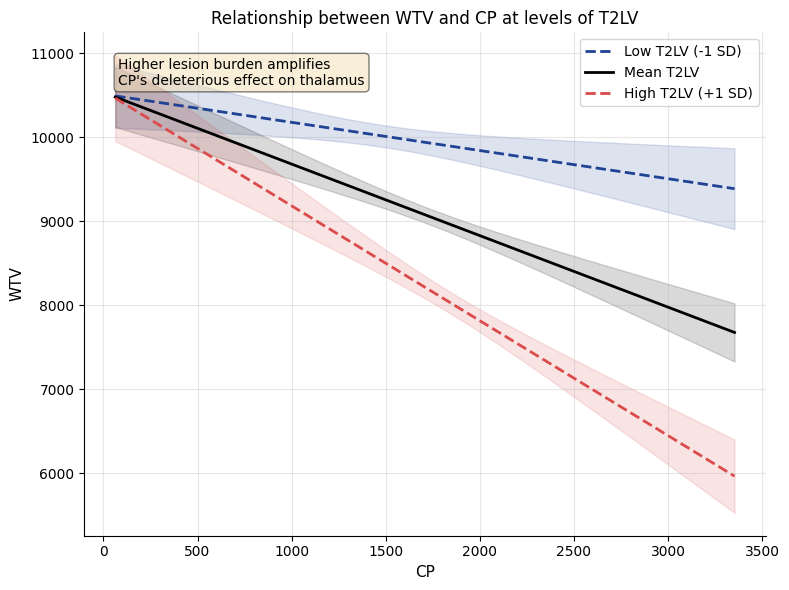

In [43]:
# Prepare data
plot_data = data[MS_patients].copy()
plot_data['Female'] = pd.to_numeric(plot_data['Female'])

x_name, w_name, y_name = "CP", "T2LV_log1p", "WTV"
xcent_name, wcent_name = f"{x_name}_cent", f"{w_name}_cent"
covariates = ["age", "Female", "tiv"]

# Center predictors
plot_data[xcent_name] = plot_data[x_name] - plot_data[x_name].mean()
plot_data[wcent_name] = plot_data[w_name] - plot_data[w_name].mean()

# Fit model
formula = f"{y_name} ~ {wcent_name}*{xcent_name} + {' + '.join(covariates)}"
res = sm.OLS.from_formula(formula, data=plot_data).fit()

# Get interaction coefficient to verify direction
interaction_coef = res.params[f"{wcent_name}:{xcent_name}"]
interaction_p = res.pvalues[f"{wcent_name}:{xcent_name}"]
print(f"Interaction coefficient: {interaction_coef:.4f}, p={interaction_p:.4f}")

# Generate predictions
exclude = ["Intercept", x_name, w_name, xcent_name, wcent_name, f"{wcent_name}:{xcent_name}"]
covars = {var: plot_data[var].mean() for var in res.model.exog_names if var not in exclude}
x_range = np.linspace(plot_data[xcent_name].min(), plot_data[xcent_name].max(), 100)
w_mean, w_std = plot_data[wcent_name].mean(), plot_data[wcent_name].std()

preds = {}
for level, w_val in [("low", w_mean - w_std), ("mid", w_mean), ("high", w_mean + w_std)]:
    test_data = pd.DataFrame({**covars, xcent_name: x_range, wcent_name: w_val})
    preds[level] = res.get_prediction(test_data).summary_frame(alpha=0.05)

x_plot = x_range + plot_data[x_name].mean()

# Plot
fig, ax = plt.subplots(figsize=(8, 6))

for level, color, style, label in [
    ("low", colors["dark blue1"], "--", "Low T2LV (-1 SD)"),
    ("mid", "black", "-", "Mean T2LV"),
    ("high", colors["dark red2"], "--", "High T2LV (+1 SD)")
]:
    pred = preds[level]
    ax.plot(x_plot, pred['mean'], label=label, linestyle=style, color=color, linewidth=2)
    ax.fill_between(x_plot, pred["mean_ci_lower"], pred["mean_ci_upper"], 
                     color=color, alpha=0.15)

ax.legend()
ax.set_xlabel(x_name, fontsize=11)
ax.set_ylabel(y_name, fontsize=11)
ax.set_title(f"Relationship between {y_name} and {x_name} at levels of T2LV", fontsize=12)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.grid(True, alpha=0.3)

if interaction_coef < 0:
    ax.text(
        0.05, 0.95, 
        "Higher lesion burden amplifies\nCP's deleterious effect on thalamus",
        transform=ax.transAxes, 
        fontsize=10, 
        verticalalignment='top',
        bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5)
    )


plt.tight_layout()
plt.show()

### T2LV moderates CP on CT

T2LV moderates the effect of CP on CT too.

In [60]:
model_data = zscore(data[MS_patients])

formulas = {
    "base": "CT ~ CP + T2LV_log1p + age + Female + tiv",
    "full": "CT ~ CP*T2LV_log1p + age + Female + tiv",
}

results, models, formulas = regutils.run_regressions_from_formulas(
    model_data, formulas.values(), model_names=formulas.keys()
)

regutils.display_results(
    results["full"],
    formula=formulas["full"],
    exclude_inds=["Intercept", "age", "Female[T.1]", "tiv"],
    same_R2=True,
)

display(Markdown("F-test and LLR test are significant here as well"))
model_comparisons = regutils.compare_models(models["base"], models["full"])
model_comparisons = pd.concat([model_comparisons], axis=1).T

display(Markdown(regutils.present_model(model_comparisons).to_markdown()))

```R
CT ~ CP*T2LV_log1p + age + Female + tiv
```

|               |    coef |    pval |     se | ci                | R2   |
|:--------------|--------:|--------:|-------:|:------------------|:-----|
| CP:T2LV_log1p | -0.1289 | 0.00013 | 0.0337 | [-0.195, -0.0627] | 0.46 |
| CP            | -0.204  | 8.4e-06 | 0.0458 | [-0.294, -0.114]  | ____ |
| T2LV_log1p    | -0.4176 | 6.4e-17 | 0.05   | [-0.516, -0.32]   | ____ |

F-test and LLR test are significant here as well

|    | base model    | full model                  |        ΔR |   F-statistic |   F-test pval |      LR |     LR pval |   df |
|---:|:--------------|:----------------------------|----------:|--------------:|--------------:|--------:|------------:|-----:|
|  0 | CP+T2LV_log1p | CP+T2LV_log1p+CP:T2LV_log1p | 0.0173887 |       15.9236 |    7.6703e-05 | 15.8925 | 6.70438e-05 |    1 |

Interaction coefficient: -0.0000, p=0.0001


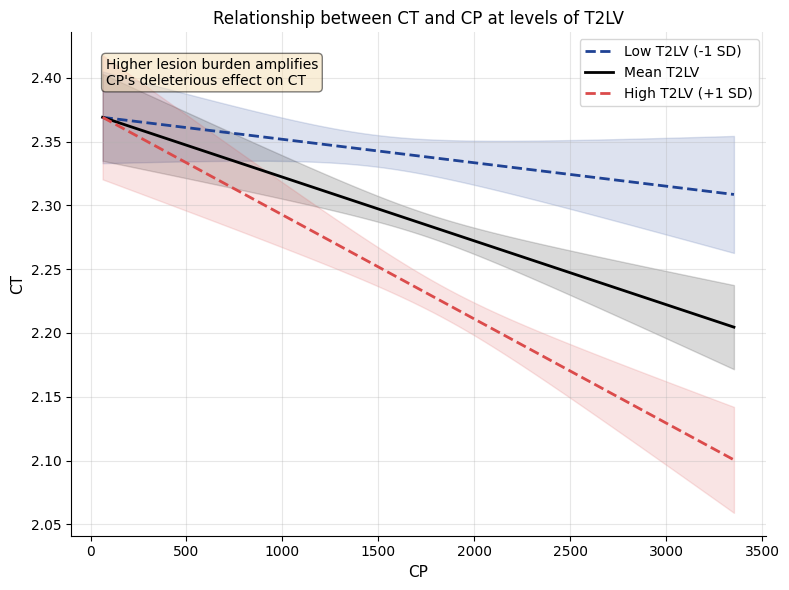

In [46]:
# Prepare data
plot_data = data[MS_patients].copy()
plot_data['Female'] = pd.to_numeric(plot_data['Female'])

x_name, w_name, y_name = "CP", "T2LV_log1p", "CT"
xcent_name, wcent_name = f"{x_name}_cent", f"{w_name}_cent"
covariates = ["age", "Female", "tiv"]

# Center predictors
plot_data[xcent_name] = plot_data[x_name] - plot_data[x_name].mean()
plot_data[wcent_name] = plot_data[w_name] - plot_data[w_name].mean()

# Fit model
formula = f"{y_name} ~ {wcent_name}*{xcent_name} + {' + '.join(covariates)}"
res = sm.OLS.from_formula(formula, data=plot_data).fit()

# Get interaction coefficient to verify direction
interaction_coef = res.params[f"{wcent_name}:{xcent_name}"]
interaction_p = res.pvalues[f"{wcent_name}:{xcent_name}"]
print(f"Interaction coefficient: {interaction_coef:.4f}, p={interaction_p:.4f}")

# Generate predictions
exclude = ["Intercept", x_name, w_name, xcent_name, wcent_name, f"{wcent_name}:{xcent_name}"]
covars = {var: plot_data[var].mean() for var in res.model.exog_names if var not in exclude}
x_range = np.linspace(plot_data[xcent_name].min(), plot_data[xcent_name].max(), 100)
w_mean, w_std = plot_data[wcent_name].mean(), plot_data[wcent_name].std()

preds = {}
for level, w_val in [("low", w_mean - w_std), ("mid", w_mean), ("high", w_mean + w_std)]:
    test_data = pd.DataFrame({**covars, xcent_name: x_range, wcent_name: w_val})
    preds[level] = res.get_prediction(test_data).summary_frame(alpha=0.05)

x_plot = x_range + plot_data[x_name].mean()

# Plot
fig, ax = plt.subplots(figsize=(8, 6))

for level, color, style, label in [
    ("low", colors["dark blue1"], "--", "Low T2LV (-1 SD)"),
    ("mid", "black", "-", "Mean T2LV"),
    ("high", colors["dark red2"], "--", "High T2LV (+1 SD)")
]:
    pred = preds[level]
    ax.plot(x_plot, pred['mean'], label=label, linestyle=style, color=color, linewidth=2)
    ax.fill_between(x_plot, pred["mean_ci_lower"], pred["mean_ci_upper"], 
                     color=color, alpha=0.15)

ax.legend()
ax.set_xlabel(x_name, fontsize=11)
ax.set_ylabel(y_name, fontsize=11)
ax.set_title(f"Relationship between {y_name} and {x_name} at levels of T2LV", fontsize=12)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.grid(True, alpha=0.3)

if interaction_coef < 0:
    ax.text(
        0.05, 0.95, 
        "Higher lesion burden amplifies\nCP's deleterious effect on CT",
        transform=ax.transAxes, 
        fontsize=10, 
        verticalalignment='top',
        bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5)
    )


plt.tight_layout()
plt.show()

### Modelling EDSS

#### WTV alone mediates the effect of CP on EDSS

Although CP does not have a significant baseline association with EDSS, it does have a significant indirect effect through WTV. It does not have an effect through WBV when the WTV pathway is tested in parallel.

In [61]:
model_data = data_ms_z

p2 = Process(
    data=model_data,
    model=4,
    x="CP",
    y="EDSS_sqrt",
    m=["WTV", "CT"],
    controls=["age", "Female", "tiv", "dzdur"],
    controls_in="all",
    suppr_init=True,
)

print("=" * 80 + "\n")
print(p2.direct_model.summary())
print(p2.indirect_model.summary())
print("=" * 80)


Direct effect of CP on EDSS_sqrt:

  Effect     SE       t      p    LLCI   ULCI
 -0.0649 0.0499 -1.3016 0.1937 -0.1627 0.0328

Indirect effect of CP on EDSS_sqrt:

       Effect  Boot SE  BootLLCI  BootULCI
  WTV  0.0931   0.0314    0.0382    0.1592
   CT  0.0254   0.0180   -0.0069    0.0635




#### Full moderated mediation model

Does T2LV's moderation extend through the entire indirect pathway

In [177]:
model_data = zscore(data[MS_patients])

p2 = Process(
    data=model_data,
    model=7,
    x="CP",
    y="EDSS_sqrt",
    m=["WTV"],
    w="T2LV_log1p",
    controls=["age", "Female", "tiv", "dzdur"],
    controls_in="all",
    suppr_init=True,
)

print("=" * 80 + "\n")
print(p2.direct_model.summary())
print("-" * 80, "\n")
print(p2.indirect_model.summary())
print("=" * 80)


Direct effect of CP on EDSS_sqrt:

  Effect     SE       t      p    LLCI   ULCI
 -0.0600 0.0498 -1.2042 0.2292 -0.1575 0.0376

-------------------------------------------------------------------------------- 

Conditional indirect effect(s) of CP on EDSS_sqrt at values of the moderator(s):

 Mediator  T2LV_log1p  Effect  Boot SE  BootLLCI  BootULCI
      WTV     -0.9791  0.0274   0.0155    0.0025    0.0651
      WTV      0.0208  0.0719   0.0203    0.0390    0.1198
      WTV      1.0207  0.1164   0.0298    0.0671    0.1839

**************** INDEX OF MODERATED MEDIATION ******************

   Moderator Mediator  Index  Boot SE   LLCI   ULCI
  T2LV_log1p      WTV 0.0445   0.0124 0.0240 0.0732




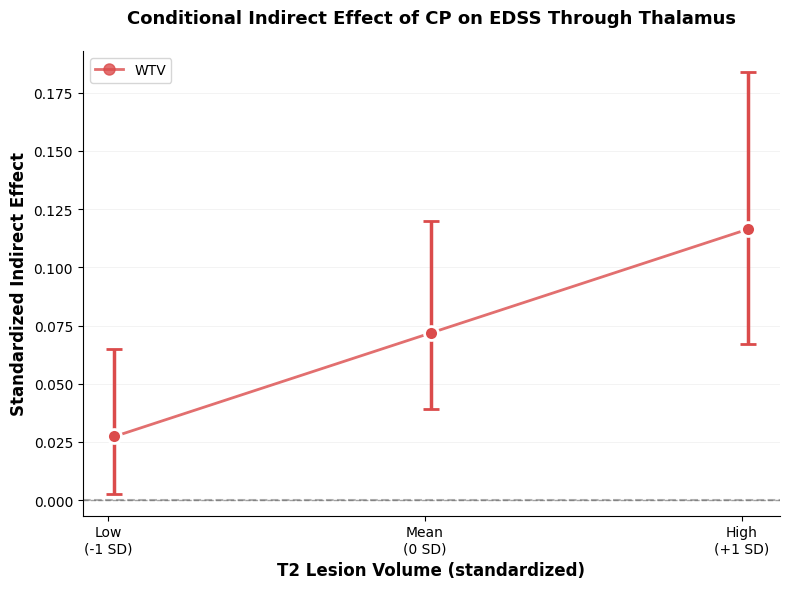

In [ ]:
moderator = "T2LV_log1p"
xlabel = "T2 Lesion Volume (standardized)"
ylabel = "Standardized Indirect Effect"
title = "Conditional Indirect Effect of CP on EDSS Through Thalamus"
plot_colors = [colors["dark red2"]]
plot_moderated_mediation(
    p2, moderator, xlabel=xlabel, ylabel=ylabel, title=title, plot_colors=plot_colors
)

Although we already saw that WBV does not mediate CP's effect on EDSS when the WTV pathway is accounted for, lets look at the plot with both mediators to drive home the point

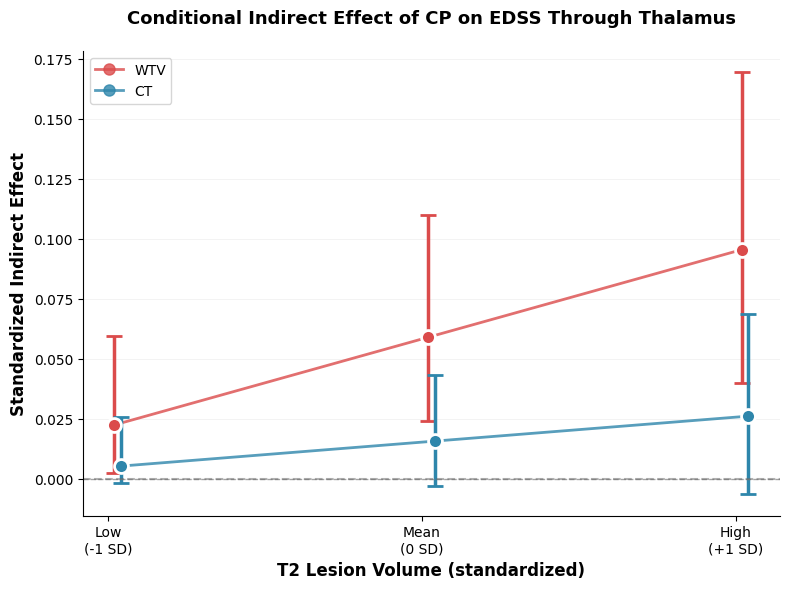

In [ ]:
model_data = zscore(data[MS_patients])

p2 = Process(
    data=model_data,
    model=7,
    x="CP",
    y="EDSS_sqrt",
    m=["WTV", "CT"],
    w="T2LV_log1p",
    controls=["age", "Female", "tiv", "dzdur"],
    controls_in="all",
    suppr_init=True,
)

# print("="*80 + "\n")
# print(p2.direct_model.summary())
# print("-"*80, "\n")
# print(p2.indirect_model.summary())
# print("="*80)

moderator = "T2LV_log1p"
xlabel = "T2 Lesion Volume (standardized)"
ylabel = "Standardized Indirect Effect"
title = "Conditional Indirect Effect of CP on EDSS Through Thalamus"
plot_colors = [colors["dark red2"], colors["dark blue2"]]

plot_moderated_mediation(
    p2, moderator, xlabel=xlabel, ylabel=ylabel, title=title, plot_colors=plot_colors
)

### Modelling SDMT

#### WTV and CT mediate CP on SDMT in parallel


In [63]:
model_data = data_ms_z

p2 = Process(
    data=model_data,
    model=4,
    x="CP",
    y="SDMT",
    m=["WTV", "CT"],
    controls=["age", "Female", "tiv", "dzdur"],
    controls_in="all",
    suppr_init=True,
)

print("=" * 80 + "\n")
print(p2.direct_model.summary())
print(p2.indirect_model.summary())
print("=" * 80)


Direct effect of CP on SDMT:

  Effect     SE      t      p    LLCI   ULCI
  0.0104 0.0512 0.2031 0.8392 -0.0899 0.1107

Indirect effect of CP on SDMT:

       Effect  Boot SE  BootLLCI  BootULCI
  WTV -0.0900   0.0339   -0.1607   -0.0287
   CT -0.0760   0.0228   -0.1263   -0.0357




#### Full moderated mediation model

T2LV amplifies both indirect pathways

In [64]:
model_data = zscore(data[MS_patients])

p2 = Process(
    data=model_data,
    model=7,
    x="CP",
    y="SDMT",
    m=["WTV", "CT"],
    w="T2LV_log1p",
    controls=["age", "Female", "tiv", "dzdur"],
    controls_in="all",
    suppr_init=True,
)

print("=" * 80 + "\n")
print(p2.direct_model.summary())
print("-" * 80, "\n")
print(p2.indirect_model.summary())
print("=" * 80)


Direct effect of CP on SDMT:

  Effect     SE      t      p    LLCI   ULCI
  0.0104 0.0512 0.2031 0.8392 -0.0899 0.1107

-------------------------------------------------------------------------------- 

Conditional indirect effect(s) of CP on SDMT at values of the moderator(s):

 Mediator  T2LV_log1p  Effect  Boot SE  BootLLCI  BootULCI
      WTV     -0.9805 -0.0249   0.0143   -0.0613   -0.0040
      WTV      0.0167 -0.0602   0.0236   -0.1123   -0.0201
      WTV      1.0139 -0.0955   0.0362   -0.1724   -0.0323
       CT     -0.9805 -0.0198   0.0133   -0.0510    0.0024
       CT      0.0167 -0.0501   0.0172   -0.0891   -0.0211
       CT      1.0139 -0.0803   0.0262   -0.1400   -0.0355

**************** INDEX OF MODERATED MEDIATION ******************

   Moderator Mediator   Index  Boot SE    LLCI    ULCI
  T2LV_log1p      WTV -0.0354   0.0141 -0.0665 -0.0114
  T2LV_log1p       CT -0.0303   0.0118 -0.0577 -0.0112




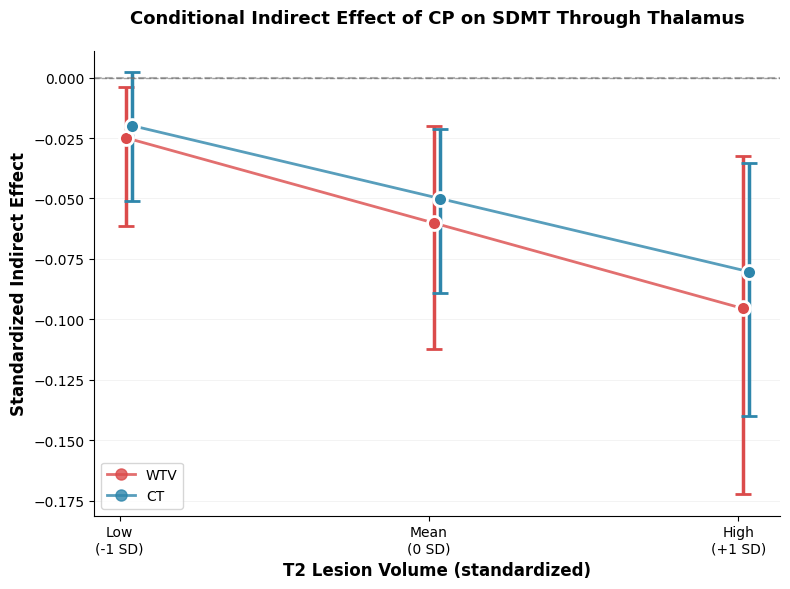

In [65]:
moderator = "T2LV_log1p"
xlabel = "T2 Lesion Volume (standardized)"
ylabel = "Standardized Indirect Effect"
title = "Conditional Indirect Effect of CP on SDMT Through Thalamus"
plot_colors = [colors["dark red2"], colors["dark blue2"]]

plot_moderated_mediation(
    p2, moderator, xlabel=xlabel, ylabel=ylabel, title=title, plot_colors=plot_colors
)

---

### Assumption Checks

Linearity

Check: Residual plots, component-residual plots
Test: Look for curved patterns in residuals vs. fitted values

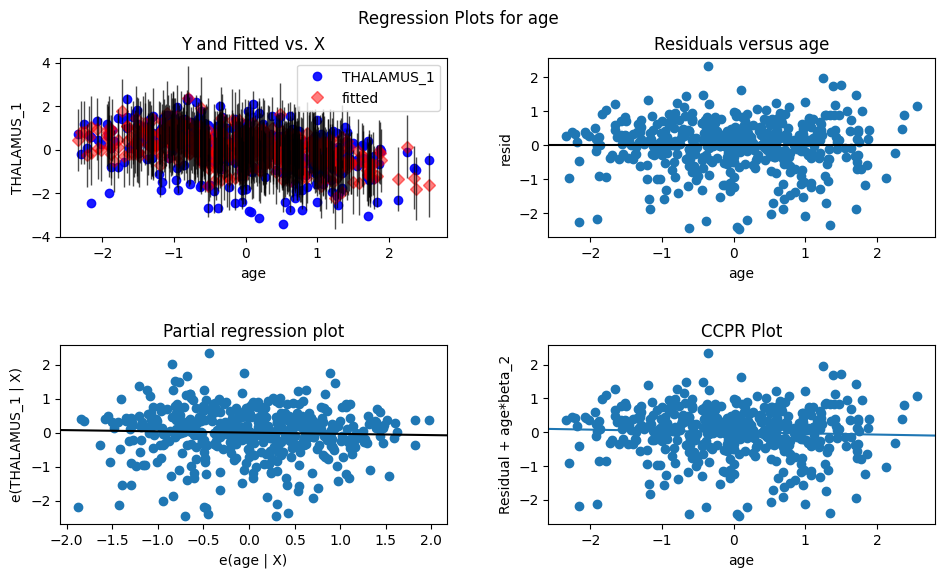

Breusch-Pagan p-value: 5.506487166550046e-07


In [ ]:
from statsmodels.stats.diagnostic import het_breuschpagan

model_data = data_ms_z

model1 = sm.OLS.from_formula(
    "THALAMUS_1 ~ CP + age + Female + tiv + dzdur", data=model_data
).fit()
# model1 = sm.OLS.from_formula("EDSS_sqrt ~ THALAMUS_1 + age + Female + tiv + dzdur", data=model_data).fit()

fig = sm.graphics.plot_regress_exog(model1, "age")
fig.set_figheight(6)
fig.set_figwidth(10)
plt.show()

bp_test = het_breuschpagan(model1.resid, model1.model.exog)
print(f"Breusch-Pagan p-value: {bp_test[1]}")

In [ ]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
import pandas as pd

# For the Thalamus model with interaction
X = model_data[["CP", "T2LV_log1p", "WTV", "CT", "age", "Female", "tiv", "dzdur"]]
X = X.dropna()
vif_data = pd.DataFrame()
vif_data["Variable"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
print(vif_data)

     Variable       VIF
0          CP  1.571211
1  T2LV_log1p  1.981889
2         WTV  3.373885
3          CT  2.246996
4         age  1.831986
5      Female  1.081938
6         tiv  1.680319
7       dzdur  1.716890


---

## Extras

In [70]:
model_data = data_ms_z
save_path = fig_path / "edss_all_predictors.xlsx"
covariates = ["age", "Female", "tiv", "dzdur"]

outcomes = ["EDSS_sqrt", "SDMT"]

predictors = [
    "WTV",
    "medial",
    "posterior",
    "ventral",
    "anterior",
    "cortical_thickness",
    "brain",
    "white",
    "grey",
    "CP",
    "t2lv_log",
    "T2LV_log1p",
    "periV_T2LV_log1p",
    "juxcort_T2LV_log1p",
    "subcort_T2LV_log1p",
    "infraT_T2LV_log1p",
    "PRL",
    "LV_log",
    "thirdV_log",
    "fourthV_log",
    "allCSF",
    "periCSF",
    # need to decide: CCR vs CCR2
    "CCR_log",
    "CCR2_log",
    "periCSF_frac_reflect_log",
]

results, _, models = regutils.run_regressions(
    model_data,
    outcomes,
    predictors,
    covariates,
)


for outcome in outcomes:
    results_to_display = results[outcome]
    display_order = (
        results_to_display["coef"].apply(np.abs).sort_values(ascending=False).index
    )
    display(Markdown(f"`{outcome} ~ *predictor* + {' + '.join(covariates)}`"))
    display(
        Markdown(
            regutils.present_model(results_to_display, presentation_cols).to_markdown()
        )
    )

`EDSS_sqrt ~ *predictor* + age + Female + tiv + dzdur`

| predictor                |    coef |   p_fdr |     se | ci                |   R2 |
|:-------------------------|--------:|--------:|-------:|:------------------|-----:|
| WTV                      | -0.2553 | 1.8e-06 | 0.0479 | [-0.349, -0.161]  | 0.29 |
| medial                   | -0.204  | 4.7e-05 | 0.046  | [-0.294, -0.114]  | 0.27 |
| posterior                | -0.2344 | 1.8e-06 | 0.0446 | [-0.322, -0.147]  | 0.29 |
| ventral                  | -0.2496 | 2.1e-05 | 0.053  | [-0.353, -0.146]  | 0.28 |
| anterior                 | -0.2149 | 6.1e-05 | 0.0496 | [-0.312, -0.118]  | 0.28 |
| cortical_thickness       | -0.195  | 4e-05   | 0.0432 | [-0.28, -0.11]    | 0.27 |
| brain                    | -0.3213 | 0.025   | 0.1384 | [-0.593, -0.0499] | 0.25 |
| white                    | -0.0655 | 0.64    | 0.1308 | [-0.322, 0.191]   | 0.24 |
| grey                     | -0.2486 | 0.012   | 0.0936 | [-0.432, -0.0651] | 0.26 |
| CP                       |  0.0535 | 0.25    | 0.0438 | [-0.0322, 0.139]  | 0.25 |
| t2lv_log                 |  0.1088 | 0.018   | 0.0434 | [0.0237, 0.194]   | 0.25 |
| T2LV_log1p               |  0.1762 | 7.4e-05 | 0.0414 | [0.095, 0.257]    | 0.27 |
| periV_T2LV_log1p         |  0.15   | 0.0013  | 0.0435 | [0.0648, 0.235]   | 0.26 |
| juxcort_T2LV_log1p       |  0.149  | 0.0012  | 0.0427 | [0.0653, 0.233]   | 0.26 |
| subcort_T2LV_log1p       |  0.0292 | 0.59    | 0.0484 | [-0.0656, 0.124]  | 0.24 |
| infraT_T2LV_log1p        |  0.1335 | 0.0013  | 0.0393 | [0.0564, 0.211]   | 0.26 |
| PRL                      |  0.1024 | 0.018   | 0.0413 | [0.0216, 0.183]   | 0.25 |
| LV_log                   |  0.1567 | 0.0014  | 0.0467 | [0.0652, 0.248]   | 0.26 |
| thirdV_log               |  0.1715 | 0.00089 | 0.0477 | [0.0781, 0.265]   | 0.27 |
| fourthV_log              |  0.0841 | 0.059   | 0.0428 | [0.000196, 0.168] | 0.25 |
| allCSF                   |  0.1632 | 0.025   | 0.0698 | [0.0263, 0.3]     | 0.25 |
| periCSF                  |  0.0264 | 0.7     | 0.0675 | [-0.106, 0.159]   | 0.24 |
| CCR_log                  |  0.1496 | 0.0014  | 0.0448 | [0.0618, 0.237]   | 0.26 |
| CCR2_log                 |  0.1525 | 0.0013  | 0.0449 | [0.0645, 0.24]    | 0.26 |
| periCSF_frac_reflect_log |  0.1682 | 0.00062 | 0.0452 | [0.0796, 0.257]   | 0.27 |

`SDMT ~ *predictor* + age + Female + tiv + dzdur`

| predictor                |    coef |   p_fdr |     se | ci                 |   R2 |
|:-------------------------|--------:|--------:|-------:|:-------------------|-----:|
| WTV                      |  0.373  | 1.4e-09 | 0.0584 | [0.258, 0.487]     | 0.25 |
| medial                   |  0.3351 | 2.3e-09 | 0.0538 | [0.23, 0.441]      | 0.23 |
| posterior                |  0.3353 | 4.9e-09 | 0.0551 | [0.227, 0.443]     | 0.24 |
| ventral                  |  0.3545 | 6.4e-09 | 0.0591 | [0.239, 0.47]      | 0.23 |
| anterior                 |  0.2659 | 9.4e-08 | 0.0483 | [0.171, 0.361]     | 0.21 |
| cortical_thickness       |  0.3614 | 4.8e-12 | 0.0491 | [0.265, 0.458]     | 0.25 |
| brain                    |  0.7955 | 2.5e-07 | 0.1498 | [0.502, 1.09]      | 0.21 |
| white                    |  0.1915 | 0.14    | 0.1306 | [-0.0645, 0.448]   | 0.16 |
| grey                     |  0.5945 | 1.5e-09 | 0.0939 | [0.411, 0.779]     | 0.22 |
| CP                       | -0.1556 | 0.0067  | 0.0562 | [-0.266, -0.0454]  | 0.17 |
| t2lv_log                 | -0.3146 | 6.4e-09 | 0.0525 | [-0.417, -0.212]   | 0.24 |
| T2LV_log1p               | -0.3245 | 1.4e-09 | 0.0506 | [-0.424, -0.225]   | 0.24 |
| periV_T2LV_log1p         | -0.2843 | 9.4e-08 | 0.0515 | [-0.385, -0.183]   | 0.22 |
| juxcort_T2LV_log1p       | -0.2307 | 3.2e-06 | 0.0485 | [-0.326, -0.136]   | 0.2  |
| subcort_T2LV_log1p       | -0.1242 | 0.012   | 0.0485 | [-0.219, -0.0291]  | 0.17 |
| infraT_T2LV_log1p        | -0.1595 | 0.00043 | 0.0444 | [-0.247, -0.0724]  | 0.18 |
| PRL                      | -0.1452 | 0.0054  | 0.0509 | [-0.245, -0.0454]  | 0.17 |
| LV_log                   | -0.2868 | 8.2e-07 | 0.0566 | [-0.398, -0.176]   | 0.21 |
| thirdV_log               | -0.2422 | 1.1e-05 | 0.0542 | [-0.348, -0.136]   | 0.2  |
| fourthV_log              | -0.0936 | 0.061   | 0.0495 | [-0.191, 0.00338]  | 0.16 |
| allCSF                   | -0.3353 | 5.4e-06 | 0.0723 | [-0.477, -0.194]   | 0.2  |
| periCSF                  | -0.1352 | 0.055   | 0.069  | [-0.271, 0.000126] | 0.16 |
| CCR_log                  | -0.2647 | 2.3e-06 | 0.0546 | [-0.372, -0.158]   | 0.21 |
| CCR2_log                 | -0.2664 | 2.2e-06 | 0.0548 | [-0.374, -0.159]   | 0.21 |
| periCSF_frac_reflect_log | -0.2559 | 1.1e-05 | 0.0572 | [-0.368, -0.144]   | 0.21 |